# UDS emulator 

## Preliminaries

In [1]:
from my_imports import *
torch.set_printoptions(precision=2, sci_mode = False)

c:\Users\agarzondiaz\surfdrive\Year 2\Paper 2 - 3.0\third_SWMM\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
yaml_path = 'config_file.yaml'
yaml_data = utils.load_yaml(yaml_path)

# Directories
simulations_path = yaml_data['simulations_path']
inp_path =  yaml_data['inp_path']

## Create simulation objects from data

In [3]:
list_of_simulations = os.listdir(simulations_path)

In [4]:
simulations = utils.extract_simulations_from_folders(simulations_path, inp_path, max_events =5)
    
event_to_test= 4

sim = simulations[event_to_test]

The file does not have [STORAGE]

The file does not have '[PUMPS]\n'
The file does not have '[ORIFICES]\n'
The file does not have '[WEIRS]\n'


In [5]:
window1 = sim.get_window(steps_ahead = 3, time = 0)
window2 = sim.get_window(steps_ahead = 3, time = 3)

In [6]:
all_windows = sim.get_all_windows(steps_ahead=3)

In [7]:
len(all_windows)

92

#### Couples of training events
Samples:

[0 to N samples] 

   [0]: x0

       [0]:rainfall values for all the timesteps (including t=0) 

       [1]:dictionary with initial depth (h0)

   [1]: y0 -> List of dictionaries containing depth at times > 0
   


In [5]:
# couples_x0_ht_1steps = utils.get_x0_ht_couples(rainfall_raw_data,head_raw_data,runoff_raw_data, steps_ahead = 1)
# couples_x0_ht_6steps = utils.get_x0_ht_couples(rainfall_raw_data,head_raw_data,runoff_raw_data, steps_ahead = 6)

#### Rolled-out validation event

In [6]:
# rolled_out_target_hydraulic_heads = []

# for dry_period in val_dry_period_indexes:
#     heads_no_rain = head_raw_data.iloc[list(dry_period), :]
#     heads = utils.get_rolled_out_target_hydraulic_heads(heads_no_rain)
    
#     rolled_out_target_hydraulic_heads.append(heads)

## Separate samples in training/validation/testing

In [7]:
x_values = [i[0] for i in couples_x0_ht_1steps]
y_values = [i[1] for i in couples_x0_ht_1steps]

In [8]:
# set aside 20% of train and test data for evaluation
X_train, X_test, y_train, y_test = train_test_split(x_values, y_values,
    test_size=0.2, shuffle = True, random_state = 8)

# Use the same function above for the validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
    test_size=0.25, random_state= 8) # 0.25 x 0.8 = 0.2

## Data preprocessing

### Normalization

In [9]:
#It considers all heads with the same scaling
norm = utils.Normalizer(X_train, y_train)

normalized_x = norm.normalized_h0_in_x
normalized_y = norm.normalized_ht_in_y

### Visualization

In [10]:
# For a single node
node_name = 'j_90492'
single_node_x = []
single_node_y = []
length_database = len(normalized_x) #same as y_train
step=1
for i in range(length_database):
    single_node_x.append(normalized_x[i][node_name])
    single_node_y.append(normalized_y[i][step-1][node_name])


In [11]:
fig = utils.plot_head_changes(node_name, single_node_x, single_node_y)
fig.show()

## Model

### Artificial Neural Network definition

In [12]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [13]:
q_transfer_ANN = QInterchangeNN().to(device)
q_runoff_ANN = QRunoffNN().to(device)

### Model definition

In [14]:
wn = DE.DynamicEmulator(inp_path, q_transfer_ANN, q_runoff_ANN)


There are no [STORAGE]
 in the file
The file does not have pumps. A handled exception occured because of '[PUMPS]\n'
The file does not have orifices. A handled exception occured because of '[ORIFICES]\n'
The file does not have weirs. A handled exception occured because of '[WEIRS]\n'


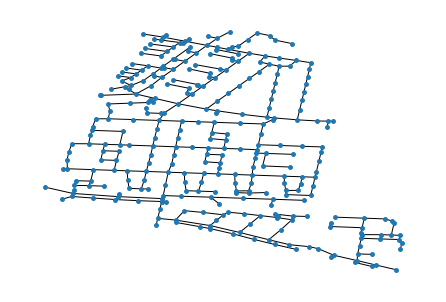

In [15]:
#Draw graph
wn.draw_nx_layout()

### Dynamic emulator

In [16]:
wn.set_h(X_train[0][1])
columns = ['Time' , 'Node', 'Depth', 'x_coord' , 'y_coord']
df = pd.DataFrame(wn.get_depths_to_rows(0), columns = columns)

for time in range(1):
    wn.update_h(runoff = X_train[0][2][time]) 
    new_h_rows = pd.DataFrame(wn.get_depths_to_rows(time+1), columns = columns)
    df = pd.concat([df,new_h_rows])

<AxesSubplot:>

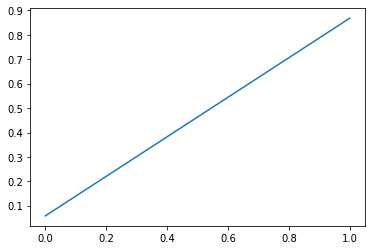

In [17]:
depth_one_node = df[df['Node']=='j_90376']['Depth'] #.plot() j_90550
depth_one_node=depth_one_node.reset_index()
depth_one_node['Depth'].plot()

In [ ]:
net = utils.animate_nodal_depth(df)
net.show()

In [ ]:
net.write_html('10_06_2022_Depth_dynamic_viz.html')

### Model training

In [18]:
losses_np=[]

In [19]:
optimizer1 = optim.SGD(wn.q_transfer_ANN.parameters(), lr=0.01, momentum=0.9)
optimizer2 = optim.SGD(wn.q_runoff_ANN.parameters(), lr=0.01, momentum=0.9)

time_steps = 1

for epoch in range(20):
    epoch_loss =[]
    for i in range(len(X_train)):
        
        wn.set_h(X_train[i][1])
        losses= []
        for time in range(time_steps):
            wn.update_h(runoff = X_train[i][2][time]) 

            pred = torch.cat(list(wn.get_h().values()))
            target = torch.reshape(torch.tensor(list(y_train[i][time].values())), (-1,1))

            loss = nn.MSELoss()(pred, target)
            losses.append(loss)

        total_loss = sum(losses)
        epoch_loss.append(total_loss.detach())
        
        if total_loss.requires_grad:
            # Backpropagate and update weights
            total_loss.backward()
            optimizer1.step()
            optimizer1.zero_grad()#set_to_none=True) 

            optimizer2.step()
            optimizer2.zero_grad()#set_to_none=True)
              
    losses_np.append(np.array(epoch_loss).mean())

tensor([[1.1453]])
tensor([[-1.1453]])
tensor([[-1.0386]])
tensor([[1.0386]])
tensor([[1.1342]])
tensor([[-1.1342]])
tensor([[-1.0569]])
tensor([[1.0569]])
tensor([[1.0373]])
tensor([[-1.0373]])
tensor([[1.1015]])
tensor([[-1.1015]])
tensor([[-1.0210]])
tensor([[1.0210]])
tensor([[1.2360]])
tensor([[-1.2360]])
tensor([[-1.1446]])
tensor([[1.1446]])
tensor([[1.1687]])
tensor([[-1.1687]])
tensor([[-1.0792]])
tensor([[1.0792]])
tensor([[1.1453]])
tensor([[-1.1453]])
tensor([[-1.0386]])
tensor([[1.0386]])
tensor([[1.1342]])
tensor([[-1.1342]])
tensor([[-1.0569]])
tensor([[1.0569]])
tensor([[1.0373]])
tensor([[-1.0373]])
tensor([[1.1015]])
tensor([[-1.1015]])
tensor([[-1.0210]])
tensor([[1.0210]])
tensor([[1.2360]])
tensor([[-1.2360]])
tensor([[-1.1446]])
tensor([[1.1446]])
tensor([[1.1687]])
tensor([[-1.1687]])
tensor([[-1.0792]])
tensor([[1.0792]])
tensor([[1.1453]])
tensor([[-1.1453]])
tensor([[-1.0386]])
tensor([[1.0386]])
tensor([[1.1342]])
tensor([[-1.1342]])
tensor([[-1.0569]])
tenso

<AxesSubplot:>

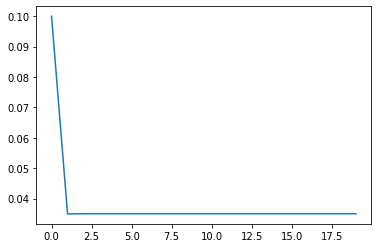

In [20]:
pd.Series(np.array(losses_np)).plot()

### Model validation

In [21]:
# wn.set_h(X_train[0][1])
# columns = ['Time' , 'Node', 'Depth', 'x_coord' , 'y_coord']
# df = pd.DataFrame(wn.get_depths_to_rows(0), columns = columns)
# dummy_validation_rain = [0,0,0,2, 3, 4, 5, 0, 0,10,0 ,0, 0, 10, 10, 20, 30, 0,0 ,0,0,0,0,0,0,0,0,0]
# for time in range(len(dummy_validation_rain)):
#     wn.update_h(rain = (dummy_validation_rain[time])/40) 
#     new_h_rows = pd.DataFrame(wn.get_depths_to_rows(time+1), columns = columns)
#     df = pd.concat([df,new_h_rows])
%time
wn.set_h(X_train[0][1])
columns = ['Time' , 'Node', 'Depth', 'x_coord' , 'y_coord']
df = pd.DataFrame(wn.get_depths_to_rows(0), columns = columns)
# dummy_validation_rain = [0,0,0,2, 3, 4, 5, 0, 0,10,0 ,0, 0, 10, 10, 20, 30, 0,0 ,0,0,0,0,0,0,0,0,0]
# training_rainfall = dummy_validation_rain#list(rainfall_raw_data.value)

runoffs = [i[2][0] for i in x_values]

for time in range(len(runoffs)):
    wn.update_h(runoff = runoffs[time]) 
    new_h_rows = pd.DataFrame(wn.get_depths_to_rows(time+1), columns = columns)
    df = pd.concat([df,new_h_rows])


CPU times: total: 0 ns
Wall time: 0 ns


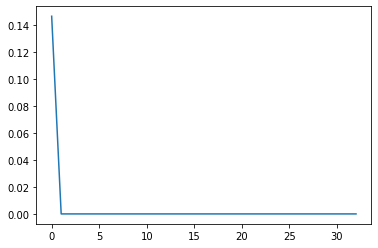

In [22]:
node_name = 'j_90708'
depth_one_node = df[df['Node']==node_name]['Depth'] #.plot() j_90550 j_90575
depth_one_node=depth_one_node.reset_index()
a = depth_one_node['Depth'].plot()

In [23]:
net = utils.animate_nodal_depth(df)
net.show()

In [26]:
net.write_html('RFTrained_Depth_dynamic_viz.html')

### Model testing

## Predictions visualization

## Export model

# Scratchpad

In [5]:
import torch
torch.__version__

'1.11.0+cpu'

In [25]:
norm.get_max_and_min_h()

(0.5452224016189575, -1.6100000143051147)